In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cuqi.distribution import JointDistribution, Gaussian, CMRF, LMRF, GMRF
from cuqi.sampler import LinearRTO, pCN, CWMH, ULA, MALA, NUTS, MH
import cuqi
from cuqi.geometry import Discrete

# Test problem: Displacements of a spring model with stiffness uncertainty
Consider af spring which is pulled at the end with a force f [N]. If the spring has uniform stiffness k [N/m], the displacement would simply be u = f/k. 
Consider now the spring having non-uniform stiffness along its length. This can be expressed as a series of linear springs with individual stiffnesses and be written as a system of linear equations.

$$Ku = f$$

The derivation of the stiffness matrix is shown below for 3 springs. Each red box is the equilibrium at each node, which depends on neigboring springs.


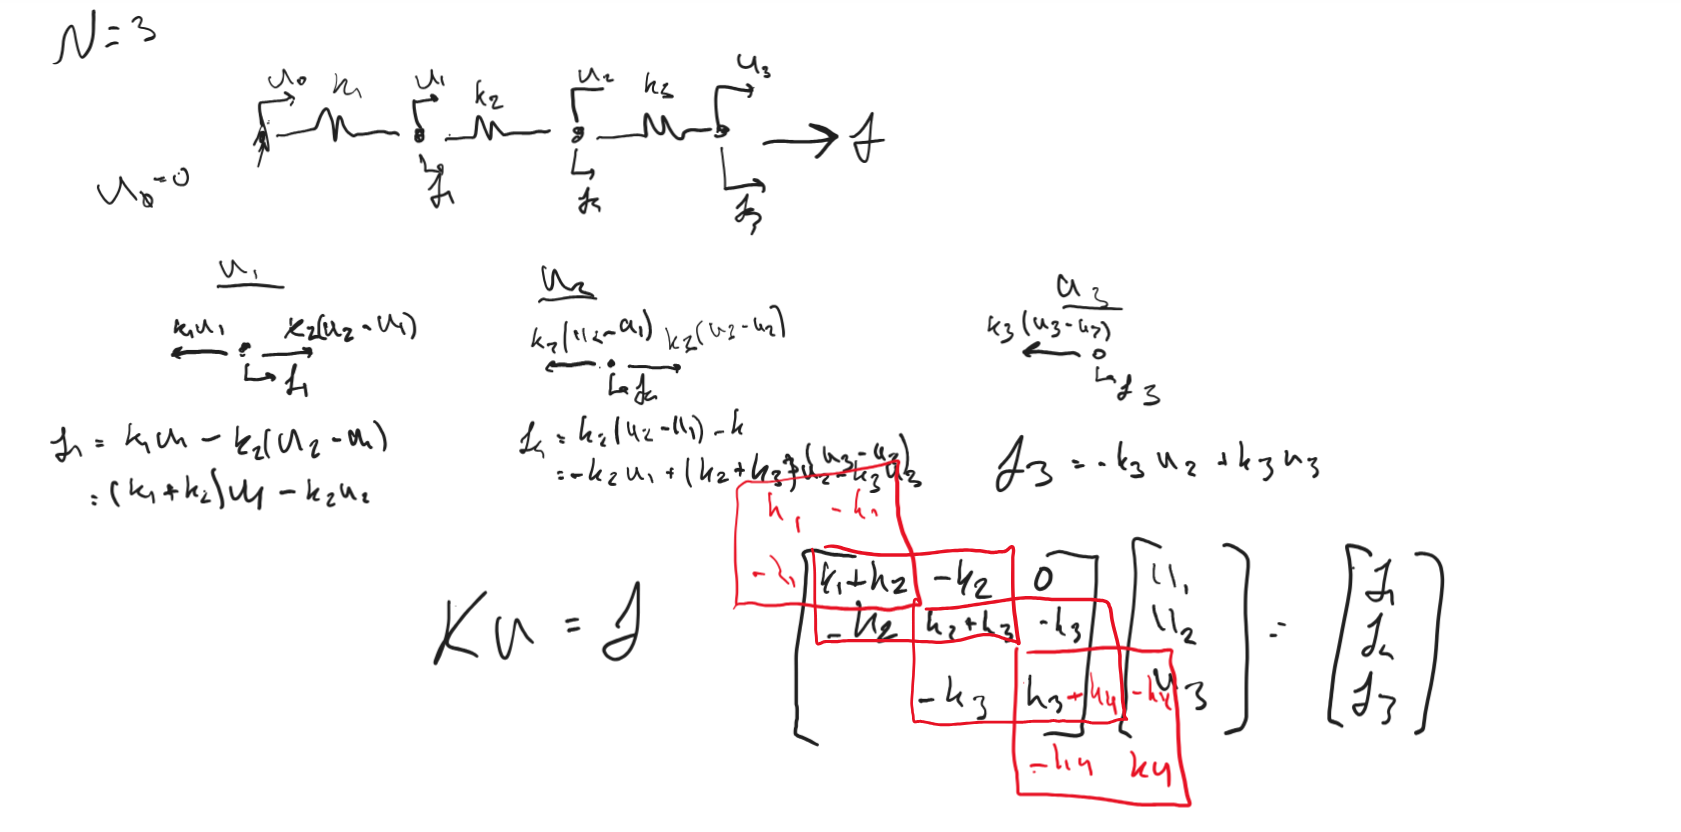

In [197]:
nelm = 5 # Number of elements
nnod = nelm+1 # Number of nodes
L = 1 # Length of bar
Le = L/nelm # Element length
F = 1 # Force at the end of bar

# Solves the linear set of equations, Ku=f, for u.
def KinvF(k):
    f = np.zeros(nnod) # Init f
    f[nelm] = F # Set force at last node of f
    K = np.zeros((nnod,nnod)) # Init stiffness matrix K
    for i in range(nelm): 
        ke = 1/Le*np.array([
            [k[i], -k[i]],
            [-k[i], k[i]]])
        
        K[i:i+2, i:i+2] += ke # Insert local stiffness matrix in K.

    K = K[1:,1:] # Apply boundary condition by removing first node
    f = f[1:]
    u = np.matmul(np.linalg.inv(K),f) # Solve for u
    return u

A general CUQI model can be created, mapping a single stiffness value to displacements

In [198]:
model_func = cuqi.model.Model(KinvF, range_geometry=nelm, domain_geometry=nelm)
print(model_func)

CUQI Model: _DefaultGeometry1D(5,) -> _DefaultGeometry1D(5,).
    Forward parameters: ['k'].


We can generate sime fake measurement data for the displacements using the model function.

5


Text(0, 0.5, 'k')

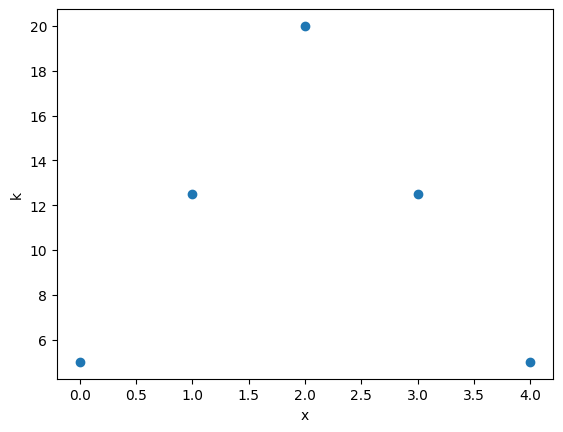

In [199]:
def hat(nelm):
    # Hat function, used for k, This is what we want to recreate using realizations
    c = 5 # Minimum value at ends
    A = 20 # Maximum value in middle
    k = np.zeros(nelm)
    print(len(k))
    incr = np.linspace(0,int(np.floor(nelm/2)-1),int(np.floor(nelm/2)))
    decr = np.linspace(int(np.floor(nelm/2)),nelm-1,int(np.ceil(nelm/2)))
    k[:int(np.floor(nelm/2))] = 2*(A-c)*(incr)/(nelm-1)+c
    k[int(np.floor(nelm/2)):] = 2*(c-A)*decr/(nelm-1)+(2*A-c)
    return k

k_exact = hat(nelm) # Setting exact values of element stiffnesses to be a hat function.


plt.figure()
plt.plot(k_exact,'o')
plt.xlabel('x')
plt.ylabel('k')


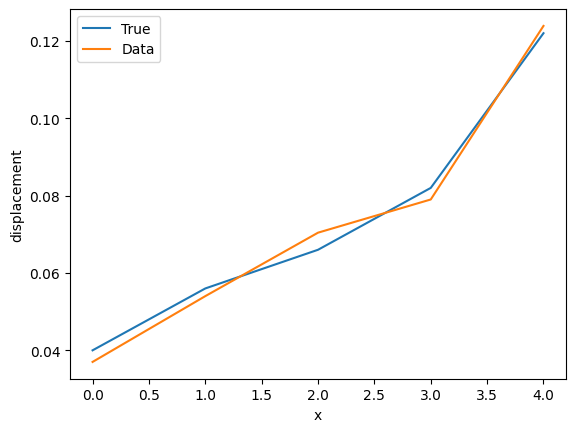

In [200]:
# The exact displacement function and perturbed displacement function can be plottet against each other.
u_exact = model_func(k=k_exact)
u_data = u_exact + 0.01*(np.random.rand(nelm)-0.5)

plt.figure()
plt.plot(u_exact)
plt.plot(u_data)
plt.xlabel('x')
plt.ylabel('displacement')
plt.legend(["True","Data"])

\begin{align*}
\mathbf{k} &\sim \mathcal{N}(k_{exact}, s_\mathbf{k}^2 I)
\end{align*}

\begin{align*}
\mathbf{u} \mid \mathbf{k} &\sim \mathcal{N}(\mathbf{K}(k)^{-1}\mathbf{f}, s_\mathbf{u}^2 \mathbf{I}),
\end{align*}

In [201]:
# Setting the prior for element stiffness k. This is the part We find difficult. It seems that the solution solely depends on the choice of prior. 
s_k = 3
k_prior = F/u_data[nelm-1]*np.ones(nelm) # k_prior is defined as the average of all springs, calculated by Force over total dispalcement (k = F/u_n), as both of these would be available.
#k_prior = k_exact
k = cuqi.distribution.Gaussian(k_prior,s_k**2)
print(k)

CUQI Gaussian.


In [202]:
# The displacement is defined based on the prior k, using the model function u = inv(K(k))F
s_u = 0.1
u = cuqi.distribution.Gaussian(model_func(k),s_u**2)
print(u)

CUQI Gaussian. Conditioning variables ['k'].


$$
p(\mathbf{u},\mathbf{k}) = p(\mathbf{u} \mid \mathbf{k})p(\mathbf{k}).
$$

\begin{align*}
p(\mathbf{k} \mid \mathbf{u}=\mathbf{u}_\mathrm{data}) \propto L(\mathbf{k} \mid \mathbf{u}=\mathbf{u}_\mathrm{data})p(\mathbf{k}),
\end{align*}

In [203]:
# Defining joint distributino
joint = JointDistribution(u, k)
print(joint)

JointDistribution(
    Equation: 
	p(u,k) = p(u|k)p(k)
    Densities: 
	u ~ CUQI Gaussian. Conditioning variables ['k'].
	k ~ CUQI Gaussian.
)


In [204]:
# Defining posterior
posterior = joint(u=u_data)
print(posterior)

Posterior(
    Equation:
	 p(k|u) ∝ L(k|u)p(k)
    Densities:
	u ~ CUQI Gaussian Likelihood function. Parameters ['k'].
 	k ~ CUQI Gaussian.
 )


Sample 10000 / 10000

Average acceptance rate: 0.8033 MCMC scale: 1 



array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>],
       [<Axes: title={'center': 'v2'}>, <Axes: title={'center': 'v2'}>],
       [<Axes: title={'center': 'v3'}>, <Axes: title={'center': 'v3'}>],
       [<Axes: title={'center': 'v4'}>, <Axes: title={'center': 'v4'}>]],
      dtype=object)

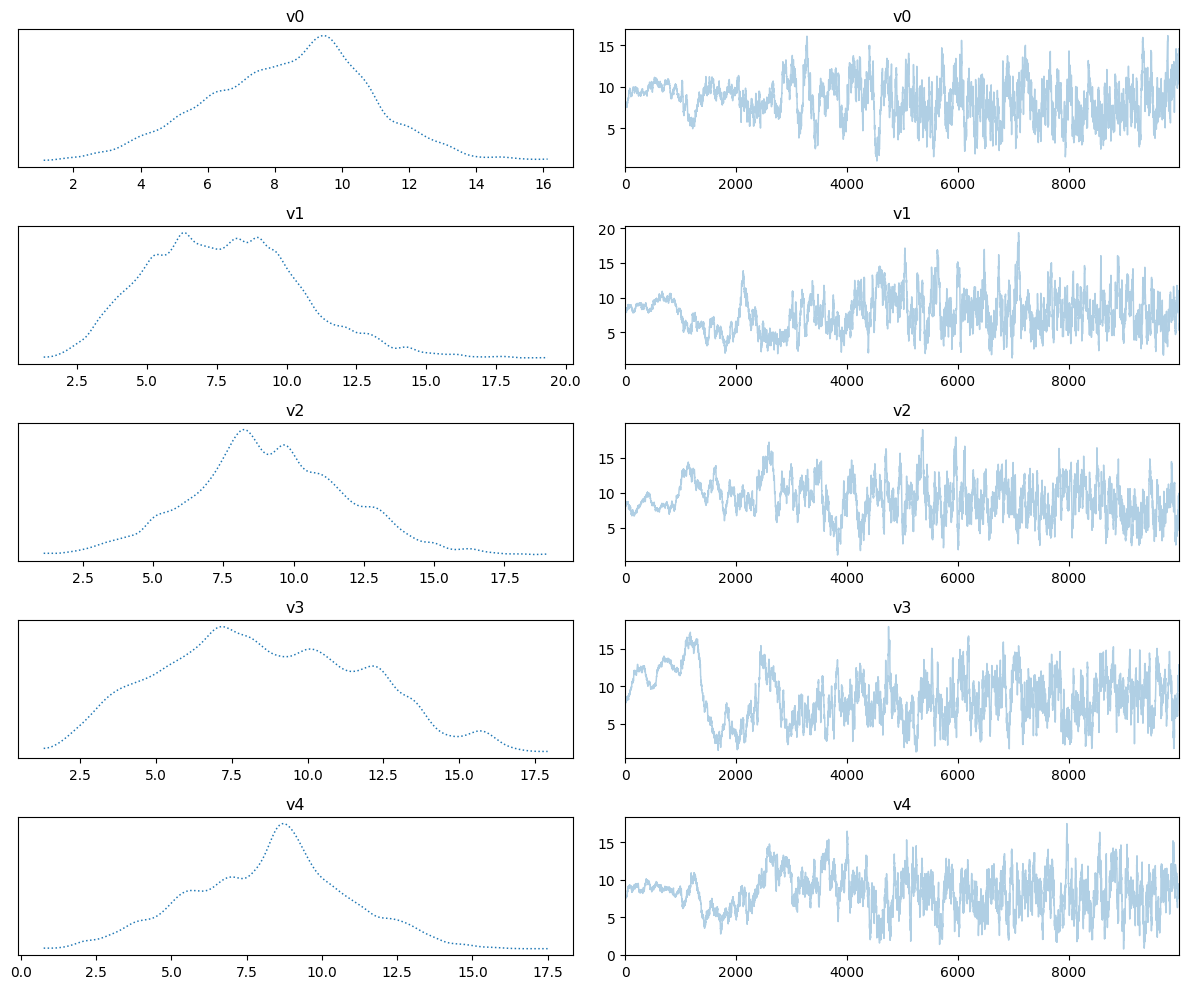

In [205]:
# Sampling the displacement
sampler = MH(posterior,x0=k_prior)
samples = sampler.sample_adapt(int(10000))
samples.plot_trace()


 <ErrorbarContainer object of 3 artists>]

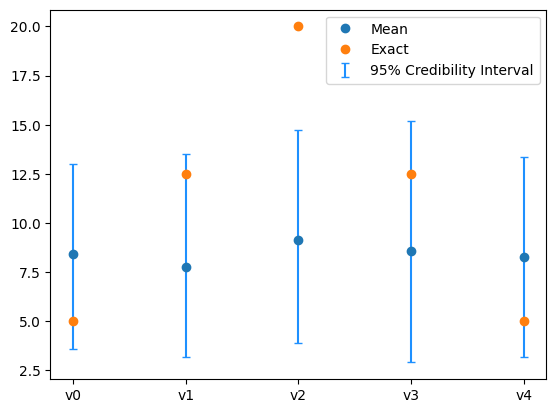

In [206]:
samples.geometry = Discrete(nelm)
samples.plot_ci(exact=k_exact)

array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>],
       [<Axes: title={'center': 'v2'}>, <Axes: title={'center': 'v2'}>],
       [<Axes: title={'center': 'v3'}>, <Axes: title={'center': 'v3'}>],
       [<Axes: title={'center': 'v4'}>, <Axes: title={'center': 'v4'}>]],
      dtype=object)

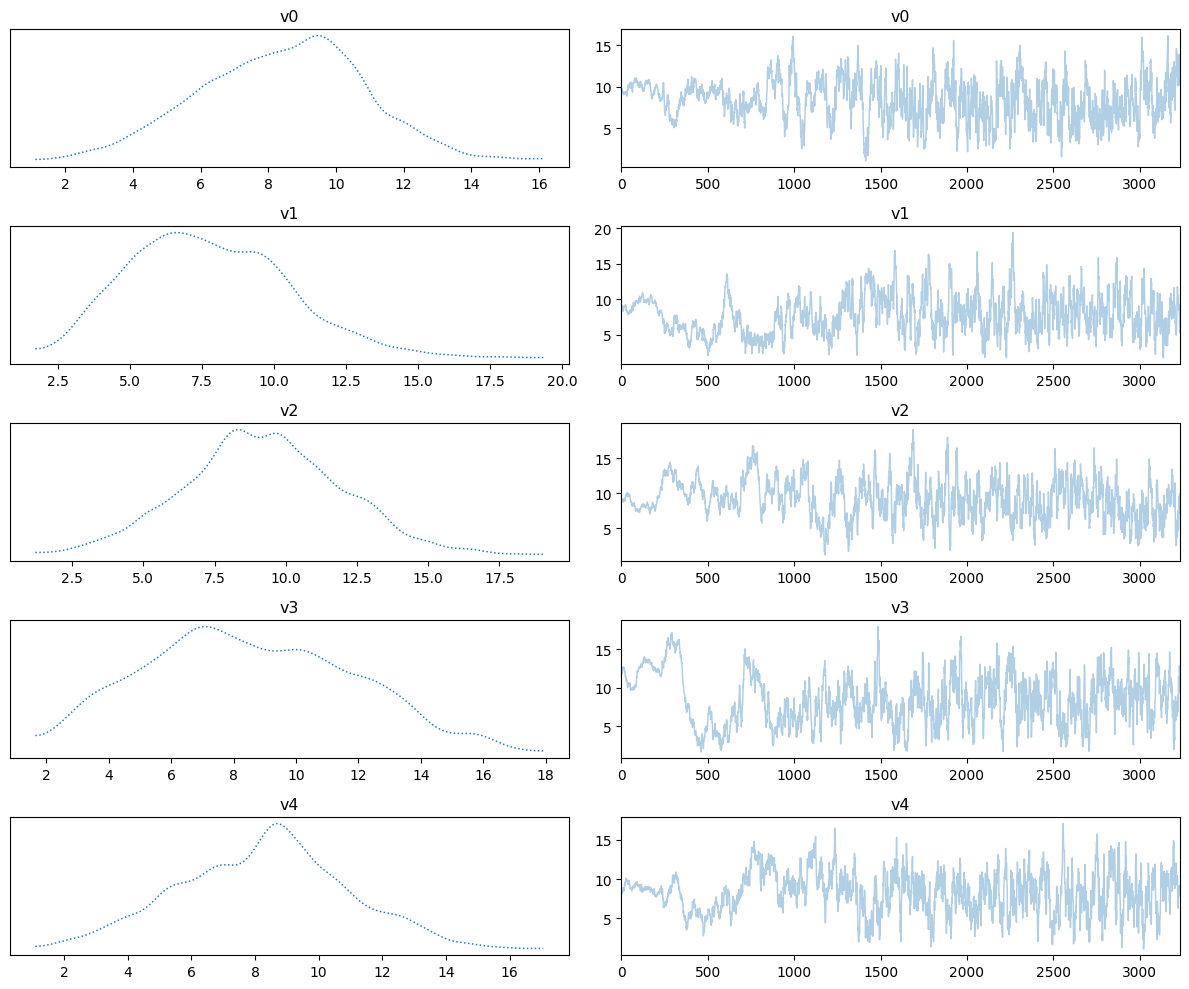

In [207]:
samples_burnthin = samples.burnthin(300, 3)
samples_burnthin.plot_trace()

 <ErrorbarContainer object of 3 artists>]

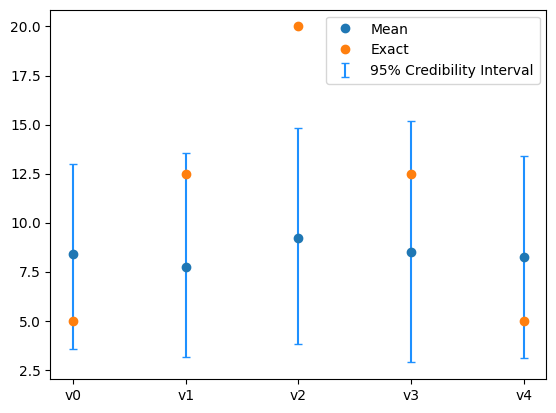

In [208]:
samples_burnthin.geometry = Discrete(nelm)
samples_burnthin.plot_ci(exact=k_exact)